In [36]:
import os
from glob import glob
from PIL import Image
import numpy as np
import torch

CLASSES130 = (
        'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 
        'bed', 'windowpane', 'grass', 'cabinet', 'sidewalk', 'person', 'earth', 
        'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car', 
        'water', 'sofa', 'shelf', 'house', 'mirror', 'rug', 'field', 
        'armchair', 'fence', 'desk', 'rock', 'wardrobe', 'lamp', 'bathtub', 
        'railing', 'cushion', 'base', 'box', 'column', 'chest of drawers', 'counter', 
        'sand', 'sink', 'skyscraper', 'fireplace', 'refrigerator', 'stairs', 'runway', 
        'case', 'pool table', 'screen door', 'river', 'bridge', 'bookcase', 'blind', 
        'coffee table', 'toilet', 'flower', 'book', 'hill', 'bench', 'stove', 
        'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar', 'arcade machine', 
        'hovel', 'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 
        'awning', 'streetlight', 'booth', 'television receiver', 'airplane', 'dirt track', 'apparel', 
        'pole', 'bannister', 'ottoman', 'bottle', 'buffet', 'stage', 'van', 
        'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'stool', 'basket', 
        'tent', 'bag', 'minibike', 'cradle', 'oven', 'ball', 'food', 
        'tank', 'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake', 
        'dishwasher', 'blanket', 'sculpture', 'sconce', 'vase', 'traffic light', 'tray', 
        'ashcan', 'fan', 'pier', 'crt screen', 'plate', 'monitor', 'shower', 
        'radiator', 'glass', 'clock', 'flag')

root_dir = "/mnt/haojun/itpsea4data/mmseg/work_dirs/20221019_vitb16_cosine_160k_bs16_coco171_in130_avgpool"
score_files = glob(os.path.join(root_dir, "cls_score_map20", "*.pth"))

def form_dict(files):
    file_dict = {}
    for f in files:
        name = f.split("/")[-1].split("_")[0]
        file = f.split("/")[-1].split(".")[0]
        if name not in file_dict:
            file_dict[name] = []
        file_dict[name].append(file)
    return file_dict

global_images = {}
global_embeddings = {}
global_scores = {}
global_all_scores = {}

def normalize(x):
    return (x - torch.mean(x, dim=-1, keepdim=True)) / torch.sqrt(torch.var(x, dim=-1, keepdim=True, unbiased=False) + 1e-5)

def get_image(file):
    img_path = os.path.join(root_dir, f"images20/{file}.png")
    if img_path in global_images:
        return global_images[img_path]
    img = np.array(Image.open(img_path))
    return img

def get_embed(file):
    emb_path = os.path.join(root_dir, f"embedding20/{file}.pth")
    if emb_path in global_embeddings:
        return global_embeddings[emb_path]
    emb = torch.load(emb_path, map_location="cpu")
    return emb

def get_score(file):
    score_path = os.path.join(root_dir, f"cls_score_map20/{file}.pth")
    if score_path in global_scores:
        return global_embeddings[score_path]
    score = torch.load(score_path, map_location="cpu")
    return score

def get_score_all(file):
    score_path = os.path.join(root_dir, f"cls_score_map_all20/{file}.pth")
    if score_path in global_all_scores:
        return global_all_scores[score_path]
    score = torch.load(score_path, map_location="cpu")
    return score

def mse(img1, img2):
    img1 = (img1 - img1.mean()) / img1.std()
    img2 = (img2 - img2.mean()) / img2.std()
    return torch.pow(img1 - img2, 2).mean()

def get_fg_pixels(files, num_seed=40):
    pixels = []
    for file in files:
        score = get_score(file)
        embed = get_embed(file)
        inds = score.flatten().topk(num_seed).indices
        pixels.append(embed.reshape(768, -1).permute(1,0)[inds])
    pixels = torch.cat(pixels)
    return pixels

def coseg_map(file, sup_files, file_dict, num_seed=40, bg_supression=False, bg_thresh=0.3, bg_topk=4, mse_thresh=1.0):
    sup_pixels = get_fg_pixels(sup_files, num_seed=num_seed).cuda()
    embed = get_embed(file).cuda()
    H, W = embed.shape[-2:]
    embed = embed.reshape(768, -1).permute(1,0)
    embed = embed / embed.norm(dim=-1, keepdim=True)
    sup_pixels = sup_pixels / sup_pixels.norm(dim=-1, keepdim=True)
    cos_mat = embed @ sup_pixels.T
    fg_score = cos_mat.mean(dim=-1)
    if not bg_supression:
        return fg_score.reshape(H, W).cpu()
    fg_name = file.split("_")[0]
    fg_cls = CLASSES130.index(fg_name)
    score_all = get_score_all(file).cuda()
    score_all = score_all.reshape(130, H * W)
    bg_scores = score_all.topk(bg_topk, dim=-1).values.mean(dim=-1)
    bg_classes = (bg_scores > bg_thresh).nonzero(as_tuple=False).flatten().tolist()
    if fg_cls in bg_classes:
        bg_classes.remove(fg_cls)
    bg_scores = []
    for bg_cls in bg_classes:
        bg_pixels = get_fg_pixels(file_dict[CLASSES130[bg_cls]], num_seed=num_seed).cuda()
        bg_pixels = bg_pixels / bg_pixels.norm(dim=-1, keepdim=True)
        cos_mat = embed @ bg_pixels.T
        bg_score = cos_mat.mean(dim=-1)
        mse_score = mse(fg_score, bg_score)
        if mse_score <= mse_thresh: 
            print(f"remove {CLASSES130[bg_cls]} {float(mse_score):.4f} from background")
            continue
        print(f"background: {CLASSES130[bg_cls]} {float(mse_score):.4f}")
        bg_scores.append(bg_score)
    bg_score = torch.stack(bg_scores, dim=0).mean(dim=0)
    return fg_score.reshape(H, W).cpu(), bg_score.reshape(H, W).cpu()

stool
background: floor 2.6552
remove chair 1.7257 from background
remove swivel chair 1.6923 from background
remove ottoman 1.7342 from background


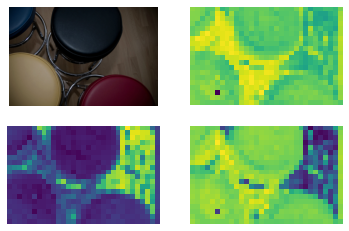

In [45]:
file_dict = form_dict(score_files)
for name in file_dict:
    if name != 'stool': continue
    print(name)
    for file in file_dict[name]:
        if 'stool_n04326896_14213' not in file: continue
        img = get_image(file)
        fg_score, bg_score = coseg_map(
            file, file_dict[name], file_dict, num_seed=10,
            bg_supression=True, bg_thresh=0.25, bg_topk=4, mse_thresh=2.0
        )
        import matplotlib.pyplot as plt
        f = plt.figure()
        f.add_subplot(2, 2, 1)
        plt.axis("off")
        plt.imshow(img)
        f.add_subplot(2, 2, 2)
        plt.axis("off")
        plt.imshow(fg_score.sigmoid())
        f.add_subplot(2, 2, 3)
        plt.axis("off")
        plt.imshow(bg_score.sigmoid())
        f.add_subplot(2, 2, 4)
        plt.axis("off")
        plt.imshow((fg_score - bg_score).sigmoid())
        # plt.savefig(os.path.join(root_dir, f"coseg_bg_supression/{file}.png"))
        plt.show()
        plt.close()
        break
    break

In [38]:
a = normalize(fg_score.flatten())
b = normalize((fg_score - bg_score).flatten())

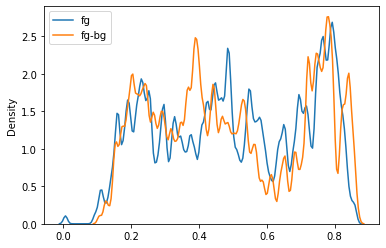

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(a.sigmoid().cpu(), bw_adjust=0.1, label="fg")
sns.kdeplot(b.sigmoid().cpu(), bw_adjust=0.1, label="fg-bg")
plt.legend()
plt.show()

In [44]:
a.min(), a.max(), b.min(), b.max()

(tensor(-4.9946), tensor(1.8133), tensor(-2.1199), tensor(1.8792))